In [ ]:
!pip install catboost
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from nltk.tokenize import word_tokenize
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
import nltk
import optuna
from sklearn.model_selection import train_test_split
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize
from wordcloud import STOPWORDS
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re
from nltk.stem.snowball import SnowballStemmer

In [ ]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [ ]:
train['content'] = train.Title + ' ' + train.Description
labels = train["Class Index"]
test['content'] = test.Title + ' ' + test.Description
test_labels = test['Class Index']

In [ ]:
test_labels = test['Class Index']

In [ ]:
def normalise_text(text):
    text = text.lower()  # lowercase
    text = text.replace(r"\#", "")  # replaces hashtags
    text = text.replace(r"http\S+", "URL")  # remove URL addresses
    text = text.replace(r"@", "")
    text = text.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ")
    text = text.replace("\s{2,}", " ")
    return text

def datacleaning(text):
    whitespace = re.compile(r"\s+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    text = whitespace.sub(' ', text)
    text = user.sub('', text)
    text = re.sub(r"\[[^()]*\]","", text)
    text = re.sub("\d+", "", text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", " ", text)
    text = text.lower()
    
    # removing stop-words
    # text = [word for word in text.split() if word not in list(STOPWORDS)]
    text = [word for word in text.split()]
    
    # word lemmatization
    sentence = []
    snow_stemmer = SnowballStemmer(language='english')
    # lemmatizer = WordNetLemmatizer()
    for word in text:
        sentence.append(snow_stemmer.stem(word))
        # sentence.append(lemmatizer.lemmatize(word,'v'))
        # sentence.append(lemmatizer.lemmatize(word))
        
    return ' '.join(text) 

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
train.content = train.content.apply(normalise_text)
test.content = test.content.apply(normalise_text)

# train.content = train.content.apply(datacleaning)
# test.content = test.content.apply(datacleaning)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train.content, labels, test_size=0.2, random_state=42)

In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 4),
                        # stop_words='english',
                        tokenizer=word_tokenize)
X_train_tfidf = tfidf.fit_transform(X_train)
X_valid_tfidf = tfidf.transform(X_valid)
X_test_tfidf = tfidf.transform(test.content)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 4),
                        # stop_words='english',
                        tokenizer=word_tokenize)
train_tfidf = tfidf.fit_transform(train.content)
test_tfidf = tfidf.transform(test.content)

In [ ]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(max_iter=10000),
    SVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0, max_iter=10000)
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    print(model_name)
    accuracies = cross_val_score(model, train_tfidf, labels, scoring='accuracy', cv=CV, verbose=3, n_jobs=3)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

RandomForestClassifier


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   5 | elapsed:   21.8s remaining:   32.6s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:   32.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


LinearSVC


[Parallel(n_jobs=3)]: Done   2 out of   5 | elapsed:   20.2s remaining:   30.2s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:   32.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


SVC


[Parallel(n_jobs=3)]: Done   2 out of   5 | elapsed: 25.7min remaining: 38.6min


KeyboardInterrupt: ignored

In [ ]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1,
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

KeyError: ignored

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy',
            data=cv_df,
            color='lightblue',
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=20);

In [ ]:
def objective(trial):
    global X_train_tfidf, y_train, X_valid_tfidf, y_valid

    c = trial.suggest_float("svc_c", 1e-4, 1e3, log=True)

    clf = LinearSVC(C=c, random_state=42, class_weight='balanced', max_iter=100000)
    clf.fit(X_train_tfidf, y_train)

    return metrics.f1_score(clf.predict(X_valid_tfidf), y_valid, average='macro')


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print(study.best_trial)

[I 2023-05-18 07:26:14,889] A new study created in memory with name: no-name-a0c17aaf-f00d-4b04-82a0-dffdb520bb15
[I 2023-05-18 07:26:21,456] Trial 0 finished with value: 0.9271248718145579 and parameters: {'svc_c': 1.203507446294642}. Best is trial 0 with value: 0.9271248718145579.
[I 2023-05-18 07:26:24,053] Trial 1 finished with value: 0.8167447778107979 and parameters: {'svc_c': 0.0002832181697743248}. Best is trial 0 with value: 0.9271248718145579.
[I 2023-05-18 07:54:48,202] Trial 2 finished with value: 0.9045115612521362 and parameters: {'svc_c': 860.817525252421}. Best is trial 0 with value: 0.9271248718145579.
[I 2023-05-18 07:54:50,512] Trial 3 finished with value: 0.8236718191165107 and parameters: {'svc_c': 0.000373788168764336}. Best is trial 0 with value: 0.9271248718145579.
[I 2023-05-18 07:54:52,702] Trial 4 finished with value: 0.8074862507507398 and parameters: {'svc_c': 0.00016528732042768145}. Best is trial 0 with value: 0.9271248718145579.
[I 2023-05-18 08:32:35,32

FrozenTrial(number=21, state=TrialState.COMPLETE, values=[0.9294492547457092], datetime_start=datetime.datetime(2023, 5, 18, 9, 6, 31, 892317), datetime_complete=datetime.datetime(2023, 5, 18, 9, 6, 36, 95032), params={'svc_c': 0.5571937097177749}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'svc_c': FloatDistribution(high=1000.0, log=True, low=0.0001, step=None)}, trial_id=21, value=None)


In [ ]:
def objective(trial):
    global X_train_tfidf, y_train, X_valid_tfidf, y_valid

    c = trial.suggest_float("lr_c", 1e-2, 1e3, log=True)

    clf = LogisticRegression(C=c, random_state=42, class_weight='balanced', max_iter=100000)
    clf.fit(X_train_tfidf, y_train)

    return metrics.f1_score(clf.predict(X_valid_tfidf), y_valid, average='macro')


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)
print(study.best_trial)

[I 2023-05-17 07:13:58,007] A new study created in memory with name: no-name-2c46dc12-d77f-4a85-bf4a-e57edccfe4f7
[I 2023-05-17 07:15:24,285] Trial 0 finished with value: 0.9209939781622242 and parameters: {'svc_c': 0.6660567207710567}. Best is trial 0 with value: 0.9209939781622242.
[I 2023-05-17 07:16:31,216] Trial 1 finished with value: 0.9187527474578103 and parameters: {'svc_c': 0.48958932972133784}. Best is trial 0 with value: 0.9209939781622242.
[I 2023-05-17 07:20:30,727] Trial 2 finished with value: 0.9225991301388836 and parameters: {'svc_c': 55.15619114575657}. Best is trial 2 with value: 0.9225991301388836.
[I 2023-05-17 07:24:55,684] Trial 3 finished with value: 0.9225645974056512 and parameters: {'svc_c': 68.78821035411143}. Best is trial 2 with value: 0.9225991301388836.
[I 2023-05-17 07:26:32,356] Trial 4 finished with value: 0.9245831073884402 and parameters: {'svc_c': 1.6694460702842122}. Best is trial 4 with value: 0.9245831073884402.
[I 2023-05-17 07:30:03,588] Tria

FrozenTrial(number=21, state=TrialState.COMPLETE, values=[0.9264213157050001], datetime_start=datetime.datetime(2023, 5, 17, 8, 7, 32, 466754), datetime_complete=datetime.datetime(2023, 5, 17, 8, 9, 50, 147217), params={'svc_c': 3.18508127085381}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'svc_c': FloatDistribution(high=100.0, log=True, low=0.1, step=None)}, trial_id=21, value=None)


In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 4),
                        stop_words='english',
                        tokenizer=word_tokenize)
train_tfidf = tfidf.fit_transform(train.content)
test_tfidf = tfidf.transform(test.content)

In [ ]:
clf = LinearSVC(C=0.5, random_state=42, class_weight='balanced', max_iter=100000).fit(train_tfidf, labels)

In [ ]:
y_pred = clf.predict(test_tfidf)

In [ ]:
# ngram = (1,4)
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.9331578947368421
F1 Score (Micro) = 0.9331578947368421
F1 Score (Macro) = 0.9330054631774833


In [ ]:
# 0.6
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.9328947368421052
F1 Score (Micro) = 0.9328947368421052
F1 Score (Macro) = 0.9327349321777229


Text(0.5, 1.0, 'CONFUSION MATRIX TF_IDF\n')

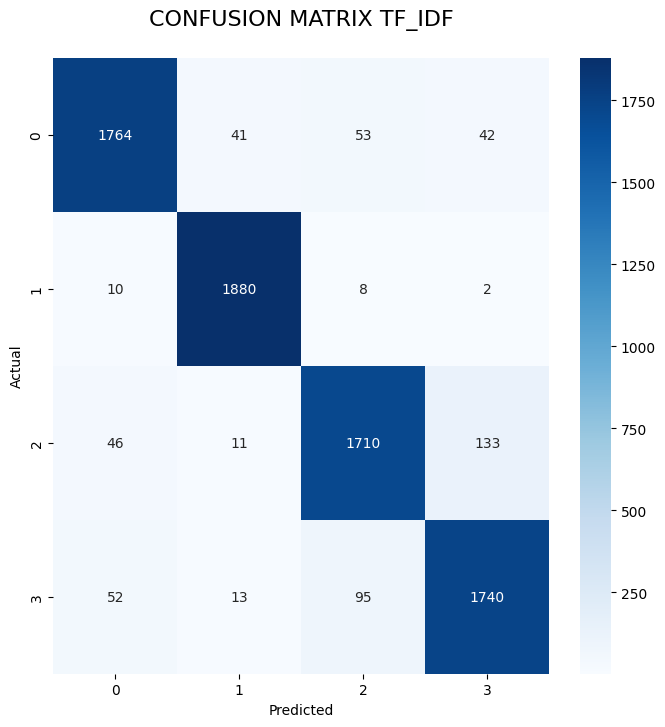

In [ ]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX TF_IDF\n", size=16)

In [ ]:
# ngram = (1,4)
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.9331578947368421
F1 Score (Micro) = 0.9331578947368421
F1 Score (Macro) = 0.9330054631774833


Text(0.5, 1.0, 'CONFUSION MATRIX TF_IDF\n')

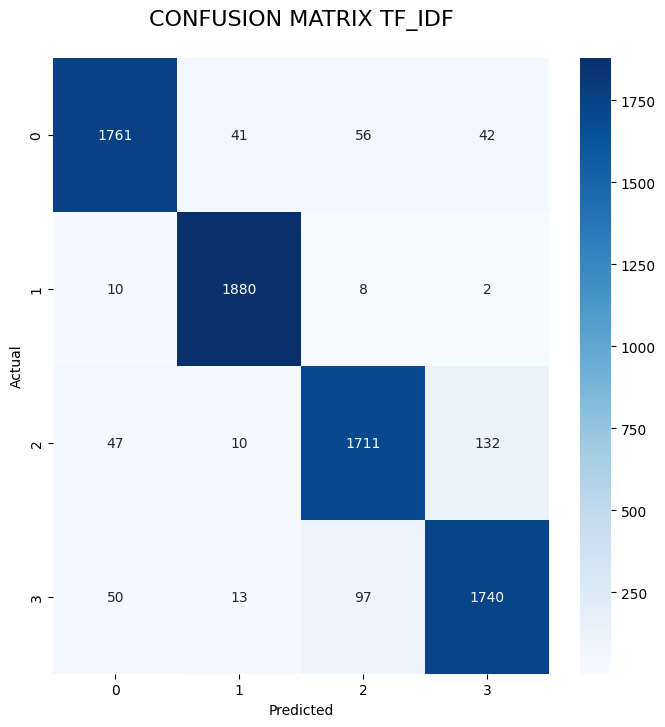

In [ ]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX TF_IDF\n", size=16)

In [ ]:
# c=0.56
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.9327631578947368
F1 Score (Micro) = 0.9327631578947368
F1 Score (Macro) = 0.9326090383121819


In [ ]:
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.9321052631578948
F1 Score (Micro) = 0.9321052631578948
F1 Score (Macro) = 0.9319555128871607


Text(0.5, 1.0, 'CONFUSION MATRIX TF_IDF\n')

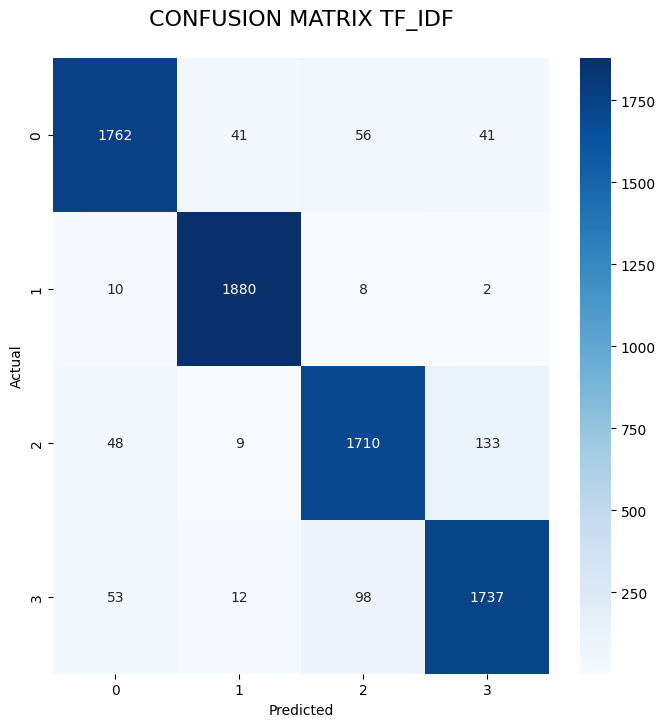

In [ ]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX TF_IDF\n", size=16)

Эксперимент 2 (Предобработка: токенизация + удаление стоп-слов + лемматизация )

In [ ]:
def objective(trial):
    global X_train_tfidf, y_train, X_valid_tfidf, y_valid

    c = trial.suggest_float("svc_c", 1e-4, 1e3, log=True)

    clf = LinearSVC(C=c, random_state=42, class_weight='balanced', max_iter=100000)
    clf.fit(X_train_tfidf, y_train)

    return metrics.f1_score(clf.predict(X_valid_tfidf), y_valid, average='macro')


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)
print(study.best_trial)

[I 2023-05-22 04:56:01,841] A new study created in memory with name: no-name-72b2584f-fbff-46bb-941b-2eba8ea95866
[I 2023-05-22 04:56:07,775] Trial 0 finished with value: 0.9227247620073608 and parameters: {'svc_c': 0.3891155445862232}. Best is trial 0 with value: 0.9227247620073608.


In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 4),
                        stop_words='english',
                        tokenizer=word_tokenize)
train_tfidf = tfidf.fit_transform(train.content)
test_tfidf = tfidf.transform(test.content)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
clf = LinearSVC(C=0.5, random_state=42, class_weight='balanced', max_iter=100000).fit(train_tfidf, labels)
y_pred = clf.predict(test_tfidf)

In [ ]:
# 0.5
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.9273684210526316
F1 Score (Micro) = 0.9273684210526316
F1 Score (Macro) = 0.9272107968720003


In [ ]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(test_labels, y_pred))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           1       0.94      0.91      0.93      1900
           2       0.96      0.98      0.97      1900
           3       0.91      0.90      0.90      1900
           4       0.90      0.91      0.91      1900

    accuracy                           0.93      7600
   macro avg       0.93      0.93      0.93      7600
weighted avg       0.93      0.93      0.93      7600



Text(0.5, 1.0, 'CONFUSION MATRIX TF_IDF\n')

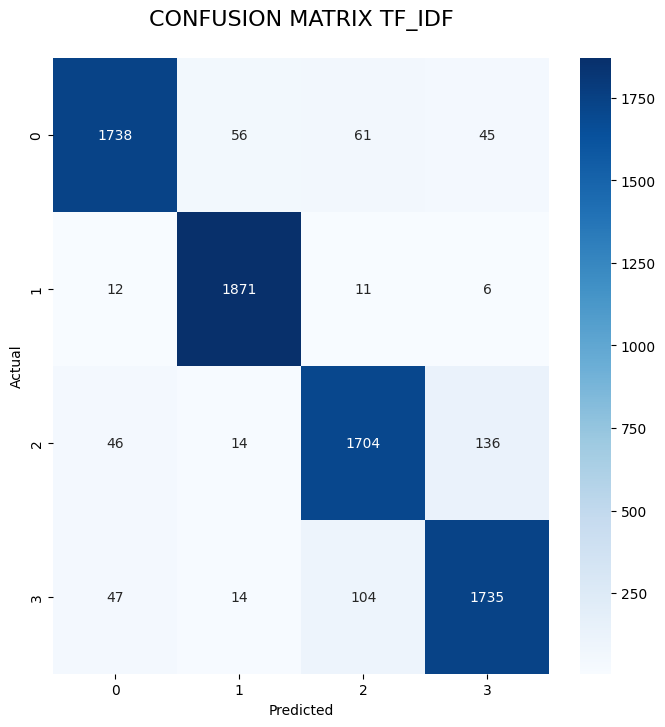

In [ ]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX TF_IDF\n", size=16)

Эксперимент 3 Токенизация + удаление стоп-слов + стемминг

In [ ]:
def objective(trial):
    global X_train_tfidf, y_train, X_valid_tfidf, y_valid

    c = trial.suggest_float("svc_c", 1e-2, 1e2, log=True)

    clf = LinearSVC(C=c, random_state=42, class_weight='balanced', max_iter=100000)
    clf.fit(X_train_tfidf, y_train)

    return metrics.f1_score(clf.predict(X_valid_tfidf), y_valid, average='macro')


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)
print(study.best_trial)

[I 2023-05-22 08:59:00,726] A new study created in memory with name: no-name-7480bd0e-a278-402b-81f2-3fc92f0a726b
[I 2023-05-22 08:59:43,565] Trial 0 finished with value: 0.9064349689098243 and parameters: {'svc_c': 17.656142299303642}. Best is trial 0 with value: 0.9064349689098243.
[I 2023-05-22 08:59:49,523] Trial 1 finished with value: 0.9226775395279554 and parameters: {'svc_c': 0.21180380754042072}. Best is trial 1 with value: 0.9226775395279554.
[I 2023-05-22 08:59:52,511] Trial 2 finished with value: 0.9128059892981264 and parameters: {'svc_c': 0.031950242178288235}. Best is trial 1 with value: 0.9226775395279554.
[I 2023-05-22 08:59:55,291] Trial 3 finished with value: 0.9150899343221535 and parameters: {'svc_c': 0.048118813531923404}. Best is trial 1 with value: 0.9226775395279554.
[I 2023-05-22 09:00:02,073] Trial 4 finished with value: 0.9189947827969543 and parameters: {'svc_c': 1.4887710020804432}. Best is trial 1 with value: 0.9226775395279554.
[I 2023-05-22 09:02:11,199

FrozenTrial(number=10, state=TrialState.COMPLETE, values=[0.9231741166270776], datetime_start=datetime.datetime(2023, 5, 22, 9, 2, 57, 589704), datetime_complete=datetime.datetime(2023, 5, 22, 9, 3, 0, 447119), params={'svc_c': 0.24014490072535108}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'svc_c': FloatDistribution(high=100.0, log=True, low=0.01, step=None)}, trial_id=10, value=None)


In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 4),
                        stop_words='english',
                        tokenizer=word_tokenize)
train_tfidf = tfidf.fit_transform(train.content)
test_tfidf = tfidf.transform(test.content)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
clf = LinearSVC(C=0.25, random_state=42, class_weight='balanced', max_iter=100000).fit(train_tfidf, labels)
y_pred = clf.predict(test_tfidf)

In [ ]:
# 0.25
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.9268421052631579
F1 Score (Micro) = 0.9268421052631579
F1 Score (Macro) = 0.9266687813124519


In [ ]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(test_labels, y_pred))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           1       0.94      0.91      0.93      1900
           2       0.96      0.99      0.97      1900
           3       0.90      0.90      0.90      1900
           4       0.90      0.91      0.91      1900

    accuracy                           0.93      7600
   macro avg       0.93      0.93      0.93      7600
weighted avg       0.93      0.93      0.93      7600



Text(0.5, 1.0, 'CONFUSION MATRIX TF_IDF\n')

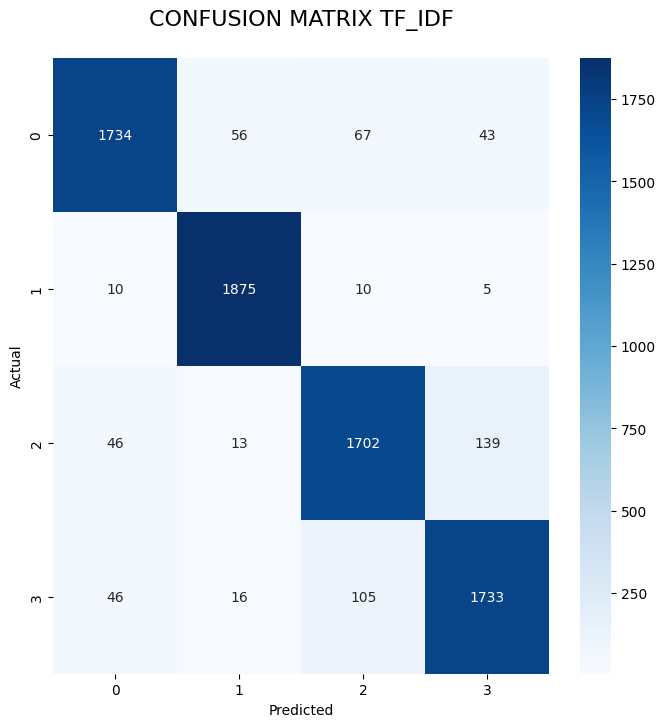

In [ ]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX TF_IDF\n", size=16)

Эксперимент 4 Токенизация + лемматизация

In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 4),
                        # stop_words='english',
                        tokenizer=word_tokenize)
train_tfidf = tfidf.fit_transform(train.content)
test_tfidf = tfidf.transform(test.content)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
clf = LinearSVC(C=0.3, random_state=42, class_weight='balanced', max_iter=100000).fit(train_tfidf, labels)
y_pred = clf.predict(test_tfidf)

In [ ]:
# 0,3
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.924078947368421
F1 Score (Micro) = 0.924078947368421
F1 Score (Macro) = 0.9239081832066423


In [ ]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(test_labels, y_pred))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           1       0.95      0.91      0.93      1900
           2       0.95      0.99      0.97      1900
           3       0.90      0.89      0.89      1900
           4       0.90      0.91      0.90      1900

    accuracy                           0.92      7600
   macro avg       0.92      0.92      0.92      7600
weighted avg       0.92      0.92      0.92      7600



Text(0.5, 1.0, 'CONFUSION MATRIX TF_IDF\n')

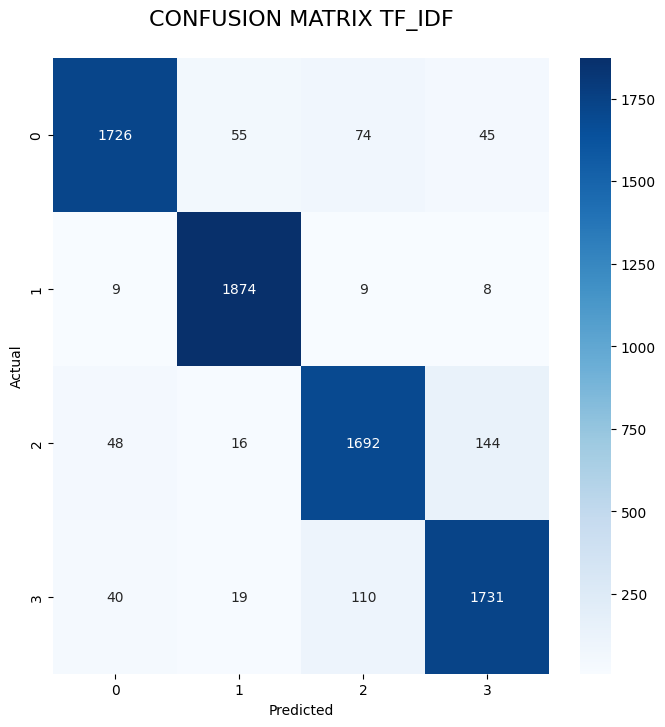

In [ ]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX TF_IDF\n", size=16)

Эксперимент 5 Токенизация + стемминг

In [ ]:
def objective(trial):
    global X_train_tfidf, y_train, X_valid_tfidf, y_valid

    c = trial.suggest_float("svc_c", 1e-2, 1e2, log=True)

    clf = LinearSVC(C=c, random_state=42, class_weight='balanced', max_iter=100000)
    clf.fit(X_train_tfidf, y_train)

    return metrics.f1_score(clf.predict(X_valid_tfidf), y_valid, average='macro')


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)
print(study.best_trial)

[I 2023-05-22 14:06:32,074] A new study created in memory with name: no-name-4bfca19c-8310-4e94-a216-62d70903fb84
[I 2023-05-22 14:07:03,028] Trial 0 finished with value: 0.9137314214699297 and parameters: {'svc_c': 8.271025369153703}. Best is trial 0 with value: 0.9137314214699297.
[I 2023-05-22 14:10:27,831] Trial 1 finished with value: 0.907825174583833 and parameters: {'svc_c': 52.579714557644905}. Best is trial 0 with value: 0.9137314214699297.
[I 2023-05-22 14:10:31,519] Trial 2 finished with value: 0.9141890839044382 and parameters: {'svc_c': 0.07129357316647748}. Best is trial 2 with value: 0.9141890839044382.
[I 2023-05-22 14:10:35,571] Trial 3 finished with value: 0.8991513112880009 and parameters: {'svc_c': 0.019580625238945423}. Best is trial 2 with value: 0.9141890839044382.
[I 2023-05-22 14:10:39,858] Trial 4 finished with value: 0.9195607725623769 and parameters: {'svc_c': 0.15910841343213308}. Best is trial 4 with value: 0.9195607725623769.
[I 2023-05-22 14:13:58,581] T

FrozenTrial(number=11, state=TrialState.COMPLETE, values=[0.921953491653573], datetime_start=datetime.datetime(2023, 5, 22, 14, 14, 26, 909267), datetime_complete=datetime.datetime(2023, 5, 22, 14, 14, 32, 137300), params={'svc_c': 0.5134109112218258}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'svc_c': FloatDistribution(high=100.0, log=True, low=0.01, step=None)}, trial_id=11, value=None)


In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 4),
                        # stop_words='english',
                        tokenizer=word_tokenize)
train_tfidf = tfidf.fit_transform(train.content)
test_tfidf = tfidf.transform(test.content)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
clf = LinearSVC(C=0.5, random_state=42, class_weight='balanced', max_iter=100000).fit(train_tfidf, labels)
y_pred = clf.predict(test_tfidf)

In [ ]:
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.9238157894736843
F1 Score (Micro) = 0.9238157894736843
F1 Score (Macro) = 0.9236521396793809


In [ ]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(test_labels, y_pred))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           1       0.94      0.91      0.93      1900
           2       0.96      0.98      0.97      1900
           3       0.90      0.89      0.89      1900
           4       0.90      0.91      0.90      1900

    accuracy                           0.92      7600
   macro avg       0.92      0.92      0.92      7600
weighted avg       0.92      0.92      0.92      7600



Text(0.5, 1.0, 'CONFUSION MATRIX TF_IDF\n')

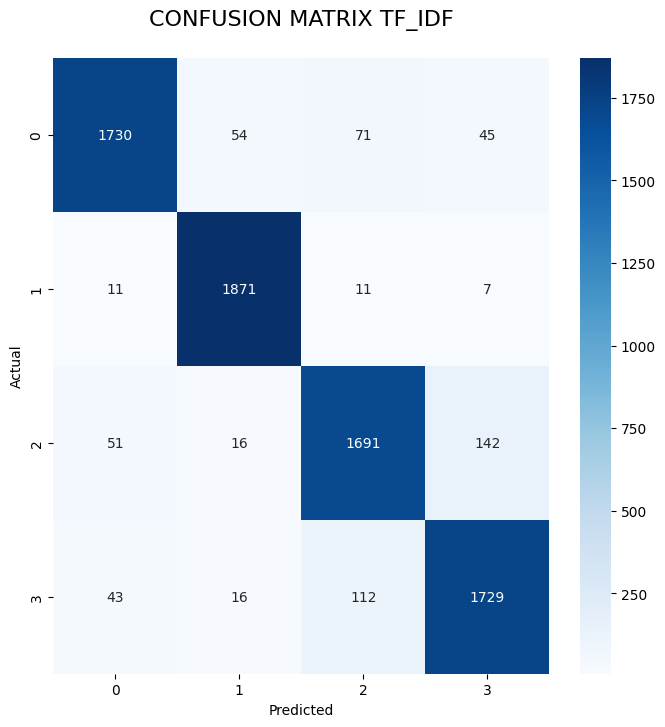

In [ ]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX TF_IDF\n", size=16)

Эксперимент 6 normalise_text

In [ ]:
def objective(trial):
    global X_train_tfidf, y_train, X_valid_tfidf, y_valid

    c = trial.suggest_float("svc_c", 1e-2, 1e2, log=True)

    clf = LinearSVC(C=c, random_state=42, class_weight='balanced', max_iter=100000)
    clf.fit(X_train_tfidf, y_train)

    return metrics.f1_score(clf.predict(X_valid_tfidf), y_valid, average='macro')


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)
print(study.best_trial)

[I 2023-05-22 14:45:51,140] A new study created in memory with name: no-name-22381105-babb-408d-a225-387d991e0b83
[I 2023-05-22 14:45:56,652] Trial 0 finished with value: 0.9004175858176824 and parameters: {'svc_c': 0.019935651589915074}. Best is trial 0 with value: 0.9004175858176824.
[I 2023-05-22 14:46:06,599] Trial 1 finished with value: 0.9263444020600248 and parameters: {'svc_c': 1.518110527101909}. Best is trial 1 with value: 0.9263444020600248.
[I 2023-05-22 14:47:31,200] Trial 2 finished with value: 0.919696533076456 and parameters: {'svc_c': 21.6190387452905}. Best is trial 1 with value: 0.9263444020600248.
[I 2023-05-22 14:49:22,712] Trial 3 finished with value: 0.919192381204109 and parameters: {'svc_c': 29.02174543398905}. Best is trial 1 with value: 0.9263444020600248.
[I 2023-05-22 14:49:47,608] Trial 4 finished with value: 0.9224040858457763 and parameters: {'svc_c': 5.43360373115125}. Best is trial 1 with value: 0.9263444020600248.
[I 2023-05-22 14:50:03,230] Trial 5 f

FrozenTrial(number=6, state=TrialState.COMPLETE, values=[0.9267436789876978], datetime_start=datetime.datetime(2023, 5, 22, 14, 50, 3, 232330), datetime_complete=datetime.datetime(2023, 5, 22, 14, 50, 9, 565290), params={'svc_c': 0.5031647688153617}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'svc_c': FloatDistribution(high=100.0, log=True, low=0.01, step=None)}, trial_id=6, value=None)


In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 4),
                        # stop_words='english',
                        tokenizer=word_tokenize)
train_tfidf = tfidf.fit_transform(train.content)
test_tfidf = tfidf.transform(test.content)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
clf = LinearSVC(C=0.5, random_state=42, class_weight='balanced', max_iter=100000).fit(train_tfidf, labels)
y_pred = clf.predict(test_tfidf)

In [ ]:
# 0.5
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.9289473684210526
F1 Score (Micro) = 0.9289473684210526
F1 Score (Macro) = 0.9288058019898164


In [ ]:
# 0.45
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.929078947368421
F1 Score (Micro) = 0.929078947368421
F1 Score (Macro) = 0.9289371505646239


In [ ]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(test_labels, y_pred))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           1       0.94      0.92      0.93      1900
           2       0.96      0.99      0.97      1900
           3       0.90      0.90      0.90      1900
           4       0.91      0.91      0.91      1900

    accuracy                           0.93      7600
   macro avg       0.93      0.93      0.93      7600
weighted avg       0.93      0.93      0.93      7600



Text(0.5, 1.0, 'CONFUSION MATRIX TF_IDF\n')

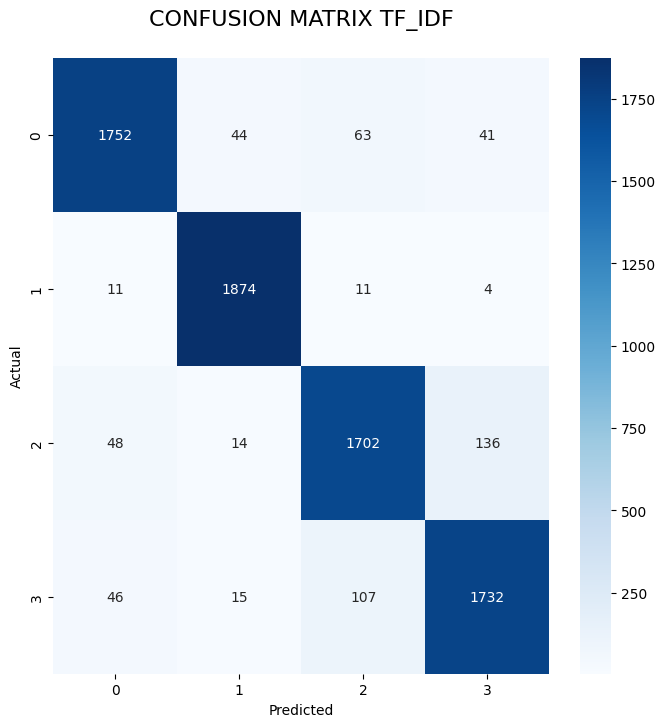

In [ ]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX TF_IDF\n", size=16)